# Climate Set

In [8]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from ds_charts import get_variable_types

datasets = ['datasets/drought.csv', 'datasets/diabetic_data.csv']
dict_path = {'Set1':datasets[1], 'Set2':datasets[0]}
dict_name = {'Set1':'diabetic', 'Set2':'climate'}
dict_target = {'Set1':'readmitted', 'Set2':'class'}

set_ID = 2

file_path = dict_path['Set'+str(set_ID)]
file_name = dict_name['Set'+str(set_ID)]
target = dict_target['Set'+str(set_ID)]
data = pd.read_csv(file_path, na_values='?', low_memory=False)
print(data.shape)

print(data[target].unique())

variables = get_variable_types(data)
numeric_vars = variables['Numeric']
symbolic_vars = variables['Symbolic']
binary_vars = variables['Binary']
date_vars = variables['Binary']

(59429, 52)
[1 0]


In [4]:
for var in binary_vars+symbolic_vars:
    if var!='date':
        print(var, (data[var].unique()))

SQ5 [1 0]
SQ6 [1 0]
class [1 0]


total: 0


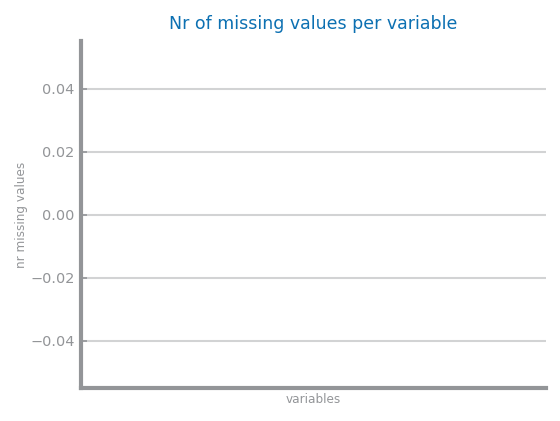

In [15]:
#missing values imputation

data_encoded = pd.read_csv(file_path, na_values='?', low_memory=False)
#no changes are needd

from matplotlib.pyplot import figure, savefig
from ds_charts import bar_chart

mv = {}
figure()
count = 0
c=0
for var in data_encoded:
    count += 1
    nr = data_encoded[var].isna().sum()
    if nr > 0:
        mv[var] = nr
        c += nr
    #print(var, nr)

print('total:', c)
bar_chart(list(mv.keys()), list(mv.values()), title='Nr of missing values per variable', xlabel='variables', ylabel='nr missing values', rotation=True)

# Missing values imputation

### No missing values

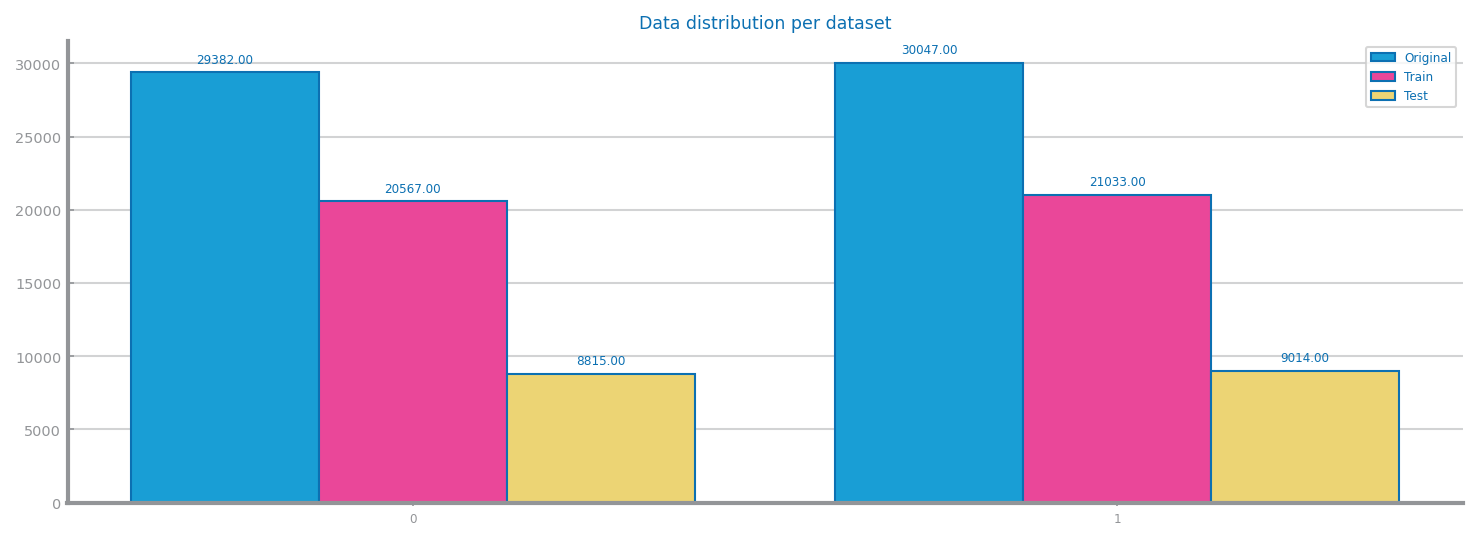

In [57]:
import numpy as np
from pandas import read_csv, concat, unique, DataFrame
import matplotlib.pyplot as plt
import ds_charts as ds
from ds_charts import multiple_bar_chart
from sklearn.model_selection import train_test_split

dataset = read_csv(file_path)
del dataset['date']

target = 'class'
values = {}

values['Original'] = [len(dataset[dataset[target] == 0]), len(dataset[data_encoded[target] == 1])]

y = dataset.pop(target).values
X = dataset.values
labels = unique(y)
labels.sort()

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

train = concat([DataFrame(trnX, columns=dataset.columns), DataFrame(trnY,columns=[target])], axis=1)
#train.to_csv(f'datasets/{file_name}_approach1_train.csv', index=False)

test = concat([DataFrame(tstX, columns=dataset.columns), DataFrame(tstY,columns=[target])], axis=1)
#test.to_csv(f'datasets/{file_name}_approach1_test.csv', index=False)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY!=0))), len(np.delete(trnY, np.argwhere(trnY!=1)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY!=0))), len(np.delete(tstY, np.argwhere(tstY!=1)))]

plt.figure(figsize=(12,4))
multiple_bar_chart(['0','1'], values, title='Data distribution per dataset')
plt.show()

## NB

0.5629592237366089


<Figure size 600x450 with 0 Axes>

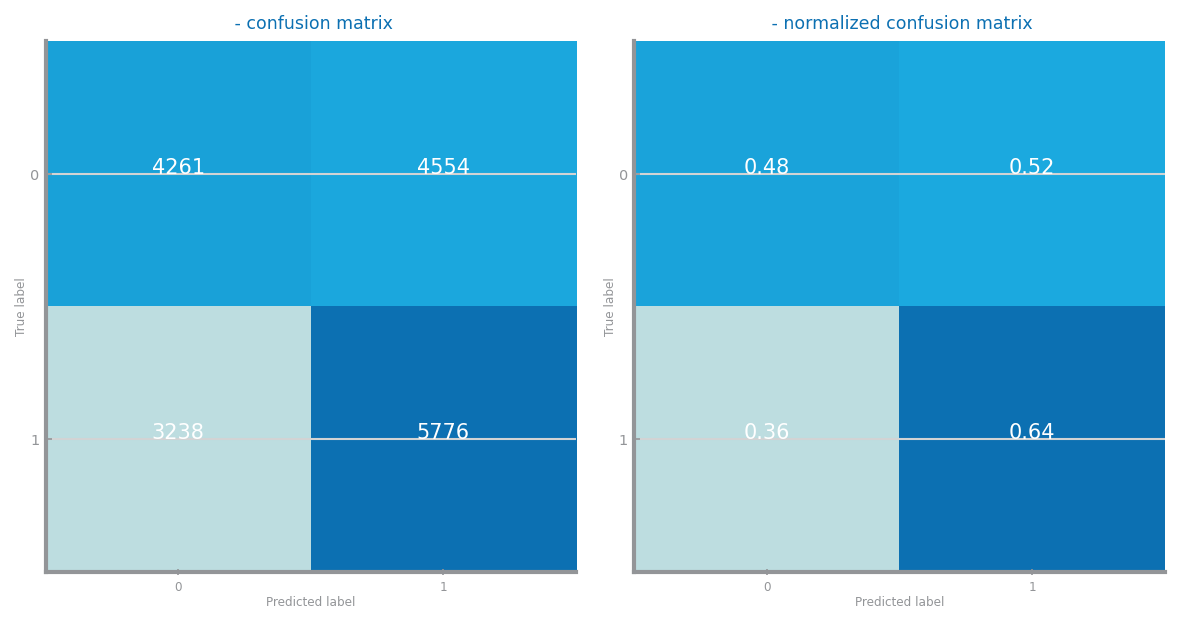

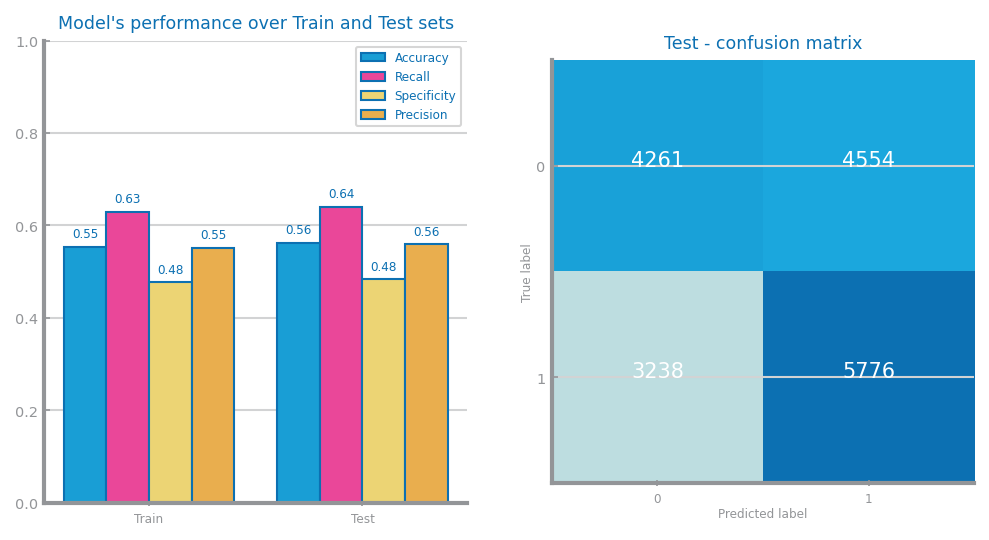

In [60]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from ds_charts import plot_evaluation_results, bar_chart, plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure, savefig, show


labels = unique(trnY)
labels.sort()

clf = GaussianNB()
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)

print(clf.score(tstX, tstY))

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
plot_confusion_matrix(confusion_matrix(tstY, prd_tst, labels=labels), labels, ax=axs[0,0], )
plot_confusion_matrix(confusion_matrix(tstY, prd_tst, labels=labels), labels, ax=axs[0,1], normalize=True)
plt.tight_layout()
plt.show()

plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
plt.show()


## KNN

In [61]:
from numpy import ndarray
from pandas import DataFrame, read_csv, unique
from matplotlib.pyplot import figure, savefig, show
from sklearn.neighbors import KNeighborsClassifier
from ds_charts import plot_evaluation_results, multiple_line_chart, plot_overfitting_study
from sklearn.metrics import accuracy_score

eval_metric = accuracy_score
nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
KNNscores = {}
best = (0, '')
last_best = 0
for d in dist:
    y_tst_values = []
    for n in nvalues:
        print(d,n)
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prd_tst_Y = knn.predict(tstX)
        y_tst_values.append(eval_metric(tstY, prd_tst_Y))
        if y_tst_values[-1] > last_best:
            best = (n, d)
            last_best = y_tst_values[-1]
    KNNscores[d] = y_tst_values

manhattan 1
manhattan 3
manhattan 5
manhattan 7
manhattan 9
manhattan 11
manhattan 13
manhattan 15
manhattan 17
manhattan 19
euclidean 1
euclidean 3
euclidean 5
euclidean 7
euclidean 9
euclidean 11
euclidean 13
euclidean 15
euclidean 17
euclidean 19
chebyshev 1
chebyshev 3
chebyshev 5
chebyshev 7
chebyshev 9
chebyshev 11
chebyshev 13
chebyshev 15
chebyshev 17
chebyshev 19


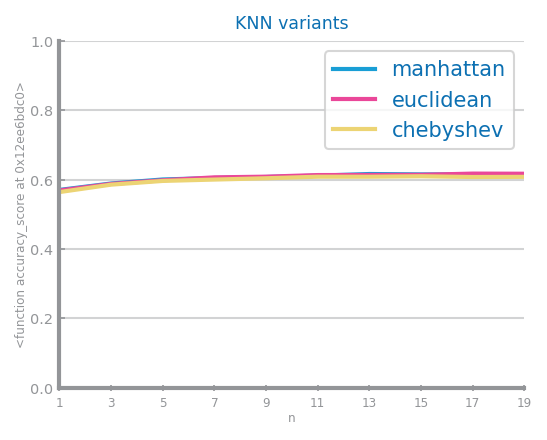

Best results with 17 neighbors and euclidean


In [62]:
from ds_charts import multiple_line_chart
figure()
multiple_line_chart(nvalues, KNNscores, title='KNN variants', xlabel='n', ylabel=str(accuracy_score), percentage=True)
#savefig('images/{file_tag}_knn_study.png')
show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

0.6170284368164227


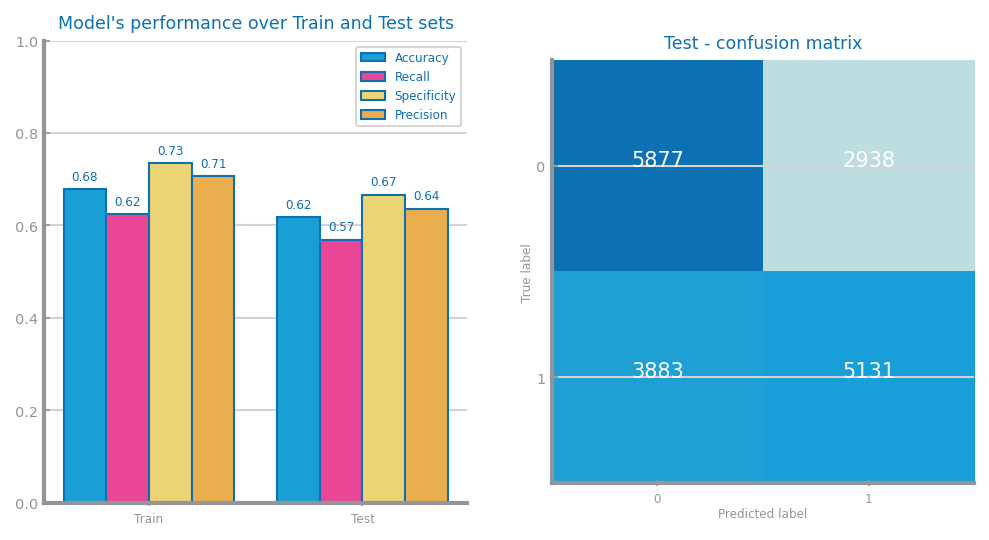

In [63]:
print(KNNscores[best[1]][9])

clf = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_tst = clf.predict(tstX)
prd_trn = clf.predict(trnX)

plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
plt.show()